In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-09-02_11-44_20180601_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
df[df['reason']=='CLOSE'].realizedPNL.count()/df.realizedPNL.count()*2

0.09901503369621566

In [5]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [6]:
#df = df.loc['20190101':'20190701']

In [7]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [8]:
allocs

NQ       0.25
ES       0.25
YM       0.25
GC       0.25
total    1.00
dtype: float64

In [9]:
df.groupby('contract').realizedPNL.sum()

contract
ES    14870.30
GC    10986.76
NQ    34044.60
YM    26156.20
Name: realizedPNL, dtype: float64

In [10]:
df.realizedPNL.sum()

86057.86

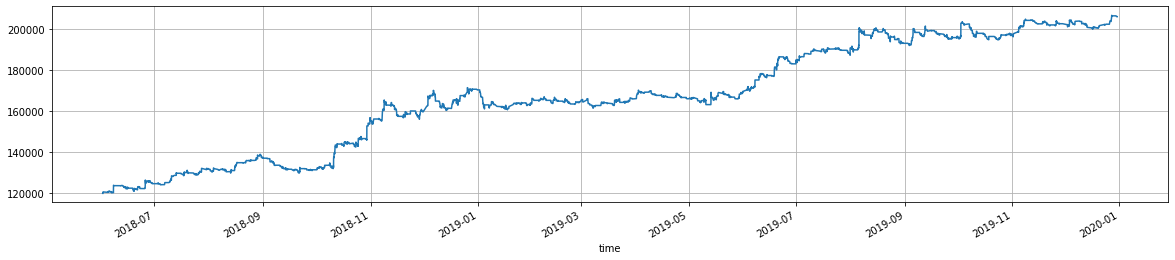

In [11]:
df.cash.plot(figsize=(20,4), grid=True);

In [12]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [13]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     533
 GC    1023
 NQ    1724
 YM     578
 Name: action, dtype: int64,
 3858)

In [14]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    1.293689
 GC    2.483010
 NQ    4.184466
 YM    1.402913
 Name: action, dtype: float64,
 9.364077669902912)

In [15]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES    1119.30
GC    2475.66
NQ    3620.40
YM    1213.80
Name: commission, dtype: float64

In [16]:
df.commission.sum()

8429.160000000002

In [17]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.39,21.50,460.89,-258.75,1.78,21.91,511.0
NQ,0.41,39.49,446.41,-244.06,1.83,39.03,862.0
YM,0.39,90.51,778.96,-357.97,2.18,85.43,289.0
ES,0.42,55.90,824.63,-494.60,1.67,59.48,266.0
total,0.40,44.64,552.80,-299.15,1.85,41.63,1928.0


In [18]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [19]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,0.047728,0.212191,0.319169,0.709066
GC,0.047728,1.000000,0.021051,0.034917,0.385763
NQ,0.212191,0.021051,1.000000,0.163033,0.607065
YM,0.319169,0.034917,0.163033,1.000000,0.653192
total,0.709066,0.385763,0.607065,0.653192,1.000000


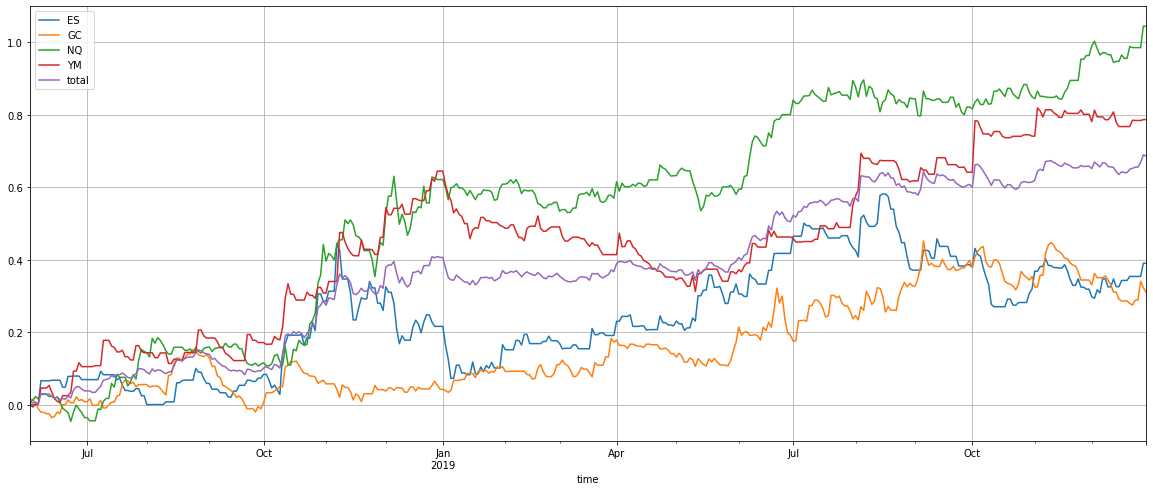

In [20]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

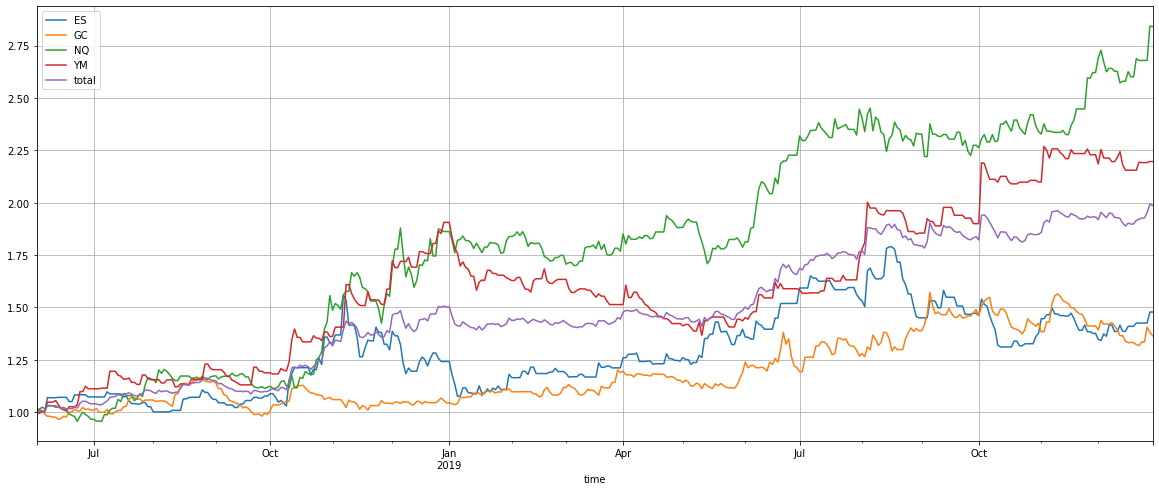

In [21]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [22]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.269730,0.209247,0.893890,0.618097,0.521567
Cumulative returns,0.477611,0.364286,1.840880,1.196372,0.986239
Annual volatility,0.363384,0.262408,0.333552,0.328297,0.194447
Sharpe ratio,0.834327,0.853640,2.080976,1.624390,2.255858
Calmar ratio,0.869161,1.288991,5.940882,2.184690,6.904404
Stability,0.640794,0.815979,0.911714,0.794957,0.938623
Max drawdown,-0.310334,-0.162334,-0.150464,-0.282922,-0.075541
Omega ratio,1.218010,1.180201,1.503767,1.528382,1.557813
Sortino ratio,1.509066,1.500356,3.861142,3.925832,4.788004
Skew,1.689230,1.084885,0.948268,3.063710,1.859227


In [23]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,7.20,0.85,-3.47,11.11,3.92
2018-07-31,-4.34,4.90,20.04,3.90,6.01
2018-08-31,3.45,8.58,1.08,4.15,4.49
2018-09-30,1.44,-13.93,-4.53,-1.24,-4.64
2018-10-31,23.60,8.23,39.15,14.61,21.52
2018-11-30,-2.48,-2.56,-0.22,16.63,3.38
2018-12-31,-4.28,0.08,19.92,20.08,8.87
2019-01-31,-4.91,6.47,-1.27,-14.19,-3.52
2019-02-28,1.09,0.50,-4.90,-0.12,-0.77


In [24]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES        48.0
GC        36.0
NQ       184.0
YM       120.0
total     99.0
dtype: float64

In [25]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2018-11-08 16:26:00,YM,SELL,26156.00,5000.8
2019-10-02 20:43:00,YM,BUY,26058.00,4590.8
2018-11-07 15:52:30,ES,SELL,2780.75,3458.3
2019-08-05 21:22:30,ES,BUY,2843.00,3408.3
2018-10-10 22:11:00,ES,BUY,2786.50,3245.8
...,...,...,...,...
2018-12-20 12:21:30,ES,BUY,2508.00,-1204.2
2018-11-15 19:24:30,ES,BUY,2718.25,-1291.7
2018-12-10 13:56:30,ES,BUY,2638.75,-1329.2


In [26]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM,total
time,,,,,
2019-08-05,0.113610,0.037011,0.035793,0.106360,0.073194
2019-10-02,0.053610,0.030688,0.018967,0.153027,0.064073
2018-12-03,0.067777,-0.003989,0.090747,0.085527,0.060015
2018-10-11,0.025690,0.057183,0.052827,0.085080,0.055195
2018-10-29,0.106527,-0.016989,0.085107,0.030693,0.051334
...,...,...,...,...,...
2019-01-03,-0.037780,-0.004828,-0.033587,-0.026973,-0.025792
2018-12-10,-0.040280,-0.001656,-0.061173,-0.000780,-0.025972
2019-01-02,-0.050973,-0.003495,-0.021780,-0.037973,-0.028555
